* [pygazer](https://www.pygaze.org/about/) - аналог webgazer для python, устаревшая библиотека для python 2.7(пофиксить ошибки + запустить не получилось)
* [openCV-gaze-tracking](https://learnopencv.com/gaze-tracking/) - используют дополнительно ИК камеры для отслеживания глаз
* [camera-to-screen](https://arxiv.org/pdf/2009.01270) - openCV + pytorch, кажется, рабочий пайплайн: на видео с камеры выделяется лицо, глаза и [точки на лице](https://github.com/google-ai-edge/mediapipe/wiki/MediaPipe-Face-Mesh), подаются на вход сверточной нейросети(в данной работе используются предобученные слои VGG16 на imagenet), которая предсказывает 3D вектор направления взгляда(gaze vector), затем этот вектор проецируется на экран в координаты (x, y) (калибровка, например, с помощью полиномиальной регрессии), в конце в идеале добавить фильтрацию(например, фильтр Калмана), чтобы взгляд не дрожал на экране. [референс код](https://github.com/pperle/gaze-tracking-pipeline/tree/main#)
* [Webcam-based gaze estimation for computer screen](https://gazerecorder.com/wp-content/uploads/2024/04/frobt-11-1369566-1.pdf) - прочитал основную часть статьи, этот подход кажется проще, чем предыдущий, хотя они очень похожи. В данной статье берут готовую модель "gaze-estimation-adas-0002" из [библиотеки](https://github.com/openvinotoolkit/openvino) для CV от Intel, которая на входе получает обрезанную часть картинки с правым глазом, с левым глазом и вектор положения головы(3 угла), а на выходе дает вектор направления взгляда единичной длины. Далее в статье показывают, как с помощью матрицы однородного преобразования(афинное без растягиваний), проецируется вектор направления взгляда в точку на экране, где расстояние от глаз до экрана оценивается с помощью регрессии(данные берутся на этапе калибровки для каждого отдельно взятого человека, в статье использовали 4 точки по разным углам монитора).

In [541]:
import openvino as ov
core = ov.Core()

In [542]:
# to download models VPN needed
# pip install openvino-dev
# omz_downloader --name <name-of-the-model> 

FACE_MODEL_PTH              = r"../../intel/face-detection-0200/FP32/face-detection-0200.xml"
HEAD_POSE_MODEL_PTH         = r"../../intel/head-pose-estimation-adas-0001/FP32/head-pose-estimation-adas-0001.xml"
FACIAL_LANDMARKS_MODEL_PTH  = r"../../intel/landmarks-regression-retail-0009/FP32/landmarks-regression-retail-0009.xml"
FACIAL_LANDMARKS_MODEL2_PTH = r"../../intel/facial-landmarks-98-detection-0001/FP32/facial-landmarks-98-detection-0001.xml"
GAZE_ESTIMATION_MODEL_PTH   = r".../../intel/gaze-estimation-adas-0002/FP32/gaze-estimation-adas-0002.xml"

In [543]:
face_detection_model = core.read_model(FACE_MODEL_PTH)
compiled_face_detection_model = core.compile_model(face_detection_model, device_name="CPU")

In [544]:
import cv2
import numpy as np

INPUT_IMG_PTH  = r"images/mark.jpg"
OUTPUT_IMG_PTH = r"images/result.png"

img = cv2.imread(INPUT_IMG_PTH)
initial_height, initial_width = img.shape[:2]

face_detection_input_shape = compiled_face_detection_model.input(0).shape
detection_h, detection_w = face_detection_input_shape[2], face_detection_input_shape[3]

resized = cv2.resize(img, (detection_w, detection_h))
input_image = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
input_image = np.transpose(input_image, (2, 0, 1)) # C W H
input_image = np.expand_dims(input_image, axis=0) # N C W H

results = compiled_face_detection_model(input_image)
output = results[compiled_face_detection_model.output(0)].squeeze()

In [545]:
THRESHOLD = 0.5

faces_count = 0
cropped_faces = []
for _, _, confidence, x_min, y_min, x_max, y_max in output:
    
    if confidence < THRESHOLD:
        break
    
    x_min, y_min = int(x_min * initial_width), int(y_min * initial_height)
    x_max, y_max = int(x_max * initial_width), int(y_max * initial_height)
    
    cropped = np.copy(img[y_min:y_max, x_min:x_max])
    cropped_faces.append(cropped)
    
    color = (0, 255, 0) # green, BGR
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, thickness=2)
    
    label = f"Face: {confidence:.2f}"
    cv2.putText(img, label, (x_min, y_min - 10), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    faces_count += 1

print(f"Faces found: {faces_count}")

Faces found: 1


(-0.5, 639.5, 639.5, -0.5)

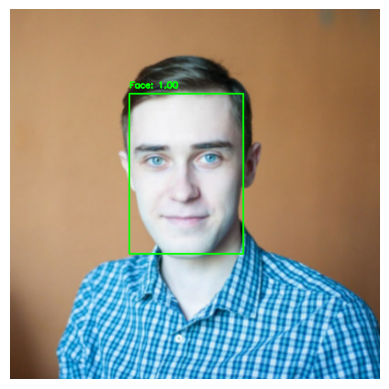

In [546]:
import matplotlib.pyplot as plt

rbg_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(rbg_img)
plt.axis("off")

In [547]:
facial_landmarks_model = core.read_model(FACIAL_LANDMARKS_MODEL_PTH)
compiled_landmarks_model = core.compile_model(facial_landmarks_model, "CPU")

In [548]:
face = cropped_faces[0]
initial_height, initial_width = face.shape[:2]

landmarks_model_input_shape = compiled_landmarks_model.input(0).shape
landmarks_h, landmarks_w = landmarks_model_input_shape[2], landmarks_model_input_shape[3]

input_image = cv2.resize(face, (landmarks_w, landmarks_h))
input_image = np.transpose(input_image, (2, 0, 1))
input_image = np.expand_dims(input_image, axis=0)
results = compiled_landmarks_model(input_image)
output = results[compiled_landmarks_model.output(0)].squeeze()

In [549]:
face_copy = np.copy(face)
for i in range(0, len(output), 2):
    x, y = int(output[i] * initial_width), int(output[i+1] * initial_height)
    
    color = (0, 0, 255)
    cv2.circle(face_copy, (x, y), 2, color, 2)
    label = f"{i}"
    cv2.putText(face_copy, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

(-0.5, 196.5, 276.5, -0.5)

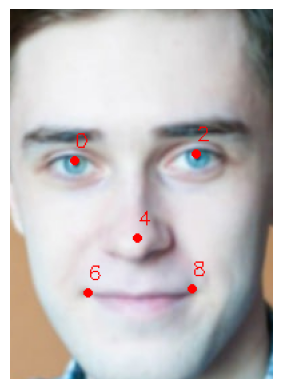

In [550]:
rgb_face = cv2.cvtColor(face_copy, cv2.COLOR_BGR2RGB)

plt.imshow(rgb_face)
plt.axis("off")

In [551]:
LEFT_EYE_CENTER = (int(output[0] * initial_width), int(output[1] * initial_height))
RIGHT_EYE_CENTER = (int(output[2] * initial_width), int(output[3] * initial_height))

In [552]:
more_landmarks_model = core.read_model(FACIAL_LANDMARKS_MODEL2_PTH)
compiled_more_landmarks_model = core.compile_model(more_landmarks_model, "CPU")

In [553]:
more_landmarks_model_input_shape = compiled_more_landmarks_model.input(0).shape
more_landmarks_model_width, more_landmarks_model_height = more_landmarks_model_input_shape[2], more_landmarks_model_input_shape[3]

In [554]:
resize_cropped_face = cv2.resize(face, (more_landmarks_model_width, more_landmarks_model_height))
resize_cropped_face = cv2.cvtColor(resize_cropped_face, cv2.COLOR_BGR2RGB)
resize_cropped_face = np.transpose(resize_cropped_face, (2, 0, 1))
resize_cropped_face = np.expand_dims(resize_cropped_face, axis=0)
results = compiled_more_landmarks_model(resize_cropped_face)
more_landmarks_output = results[compiled_more_landmarks_model.output(0)].squeeze()

In [555]:
landmarks = []
for i in range(len(more_landmarks_output)):
        heatmap = more_landmarks_output[i]
        
        max_idx = np.unravel_index(np.argmax(heatmap), heatmap.shape)
        max_val = heatmap[max_idx]
        
        if max_val < 0:
            landmarks.append(None)
            continue
            
        h_idx, w_idx = max_idx
        
        x = w_idx
        y = h_idx
        
            
        landmarks.append((x, y))

In [556]:
face_copy = np.copy(face)
EYE_INDICES = list(range(60, 76)) + [33]
RIGHT_EYE_INDICES = [0, 1, 2, 3, 4, 5, 6, 7, 16]
LEFT_EYE_INDICES  = [8, 9, 10, 11, 12, 13, 14, 15]
landmarks = np.array(landmarks)
eyes_points = [(int(x * initial_width / 16.0), int(y * initial_height / 16.0)) for x, y in landmarks[EYE_INDICES]]
eyes_points = np.array(eyes_points)
for x, y in eyes_points:
    color = (0, 0, 255)
    cv2.circle(face_copy, (x, y), 2, color, 2)

(-0.5, 196.5, 276.5, -0.5)

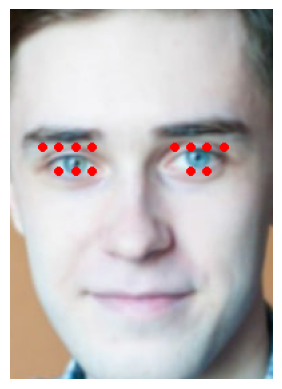

In [557]:
rgb_face = cv2.cvtColor(face_copy, cv2.COLOR_BGR2RGB)

plt.imshow(rgb_face)
plt.axis("off")

In [558]:

def get_square_crop_coords(eye_landmarks, center_point, image_shape, padding=1.0):
    min_x, max_x = np.min(eye_landmarks[:, 0]), np.max(eye_landmarks[:, 0])
    min_y, max_y = np.min(eye_landmarks[:, 1]), np.max(eye_landmarks[:, 1])
    
    width = max_x - min_x
    height = max_y - min_y
    size = max(width, height) * padding
    
    half_size = size / 2.0
    x1 = int(center_point[0] - half_size)
    y1 = int(center_point[1] - half_size)
    x2 = int(center_point[0] + half_size)
    y2 = int(center_point[1] + half_size)
    
    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(image_shape[0], x2)
    y2 = min(image_shape[1], y2)
    
    return (x1, y1, x2, y2)

In [559]:
def extract_eyes(image, landmarks):
    eyes = {}
    
    coords_left = get_square_crop_coords(landmarks[LEFT_EYE_INDICES], LEFT_EYE_CENTER, (initial_width, initial_height))
    if coords_left:
        x1, y1, x2, y2 = coords_left
        eyes['left'] = image[y1:y2, x1:x2]
        
    coords_right = get_square_crop_coords(landmarks[RIGHT_EYE_INDICES], RIGHT_EYE_CENTER, (initial_width, initial_height))
    if coords_right:
        x1, y1, x2, y2 = coords_right
        eyes['right'] = image[y1:y2, x1:x2]
        
    return eyes

In [560]:
face_copy = np.copy(face)
rgb_face  = cv2.cvtColor(face_copy, cv2.COLOR_BGR2RGB)

cropped_eyes = extract_eyes(rgb_face, eyes_points)

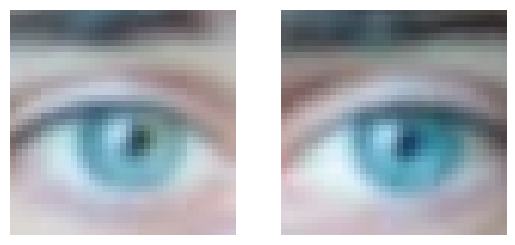

In [568]:
fig, axes = plt.subplots(1, 2)

axes[0].imshow(cropped_eyes["left"])
axes[1].imshow(cropped_eyes["right"])
for ax in axes:
    ax.axis("off")